# **IMAGE EXTRACTION AND FINE-TUNING**

## Image Data Preview

### Load Image Data (Batch from Hugging Face)

In [1]:
from datasets import load_dataset
from itertools import islice
import pandas as pd
import numpy as np
from keras.utils import to_categorical

dataset = load_dataset("DavidVivancos/MindBigData2023_MNIST-2B", split="train", streaming=True)
batch_iterator = iter(dataset)

2025-07-02 09:05:04.230785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751447104.504273      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751447104.584489      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


README.md: 0.00B [00:00, ?B/s]

In [2]:
MNIST_images = []
img_size = 28

batch_size = 3000
for i in range(20):
    print(f"Retrieving batch {i}...", flush=True)
    batch = list(islice(batch_iterator, batch_size))
    batch = pd.DataFrame(batch)

    # Remove Data with Label -1
    data = batch[batch['label'] != -1]

    # Take Selected Images' Columns
    selected_columns = [f"label_imgpix_{i}" for i in range(784)]
    data = data[selected_columns]

    # INTEGRATION AND RESHAPE
    data_array = data.values.reshape((-1, img_size, img_size))
    MNIST_images.append(data_array)

MNIST_images = np.concatenate(MNIST_images, axis=0)

Retrieving batch 0...
Retrieving batch 1...
Retrieving batch 2...
Retrieving batch 3...
Retrieving batch 4...
Retrieving batch 5...
Retrieving batch 6...
Retrieving batch 7...
Retrieving batch 8...
Retrieving batch 9...
Retrieving batch 10...
Retrieving batch 11...
Retrieving batch 12...
Retrieving batch 13...
Retrieving batch 14...
Retrieving batch 15...
Retrieving batch 16...
Retrieving batch 17...
Retrieving batch 18...
Retrieving batch 19...


#### Save and Retrieve

In [3]:
import numpy as np
np.save("MNIST_images.npy", MNIST_images)

In [1]:
import os
import numpy as np

path = "/kaggle/input/mnist-images/"
images = np.load(os.path.join(path, "MNIST_images.npy"))

### Image Data Preprocessing (for Preprocessed EEG Data)

#### Select Data with Index (Due to Thresholding in Preprocessing)

In [2]:
path = "/kaggle/input/mnist-images/"
idx = np.load(os.path.join(path, "thresholded_valid_indices.npy"))

In [3]:
selected = [images[i] for i in idx]
print(len(selected))

13716


#### Add Padding
##### (28x28) => (32x32)

In [4]:
padded = np.pad(np.array(selected), ((0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0)
print(padded.shape)

(13716, 32, 32)


In [5]:
images = np.pad(np.array(images), ((0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0)
print(images.shape)

(30000, 32, 32)


#### Duplicate Data for Augmented

In [6]:
import os
import pickle

path = '/kaggle/input/preprocessed-final-2/'
with open(os.path.join(path, "processed_eeg_data-2.pkl"), "rb") as f:
    processed = pickle.load(f)

In [7]:
print(processed.keys())

dict_keys(['X', 'y', 'augmented_indices', 'augmentation_methods', 'duplication_sources'])


In [8]:
duplicated = []
for src in processed['duplication_sources']:
    if (isinstance(src, tuple)):
        (src1, src2), lam = src
        if (lam < 0.5):
            duplicated.append(padded[src2])
        else:
            duplicated.append(padded[src1])
    else:
        duplicated.append(padded[src])

print(len(duplicated))

1744


In [9]:
combined = np.concatenate([padded, duplicated], axis=0)
print(combined.shape)

(15460, 32, 32)


#### Normalization for Image

In [ ]:
combined = (combined.float() / 255.0 - 0.5) / 0.5

### Data Understanding

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mnist_images(arr, n_samples=6, cols=3):
    rows = (n_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()

    for i in range(n_samples):
        axes[i].imshow(arr[i], cmap='gray')
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

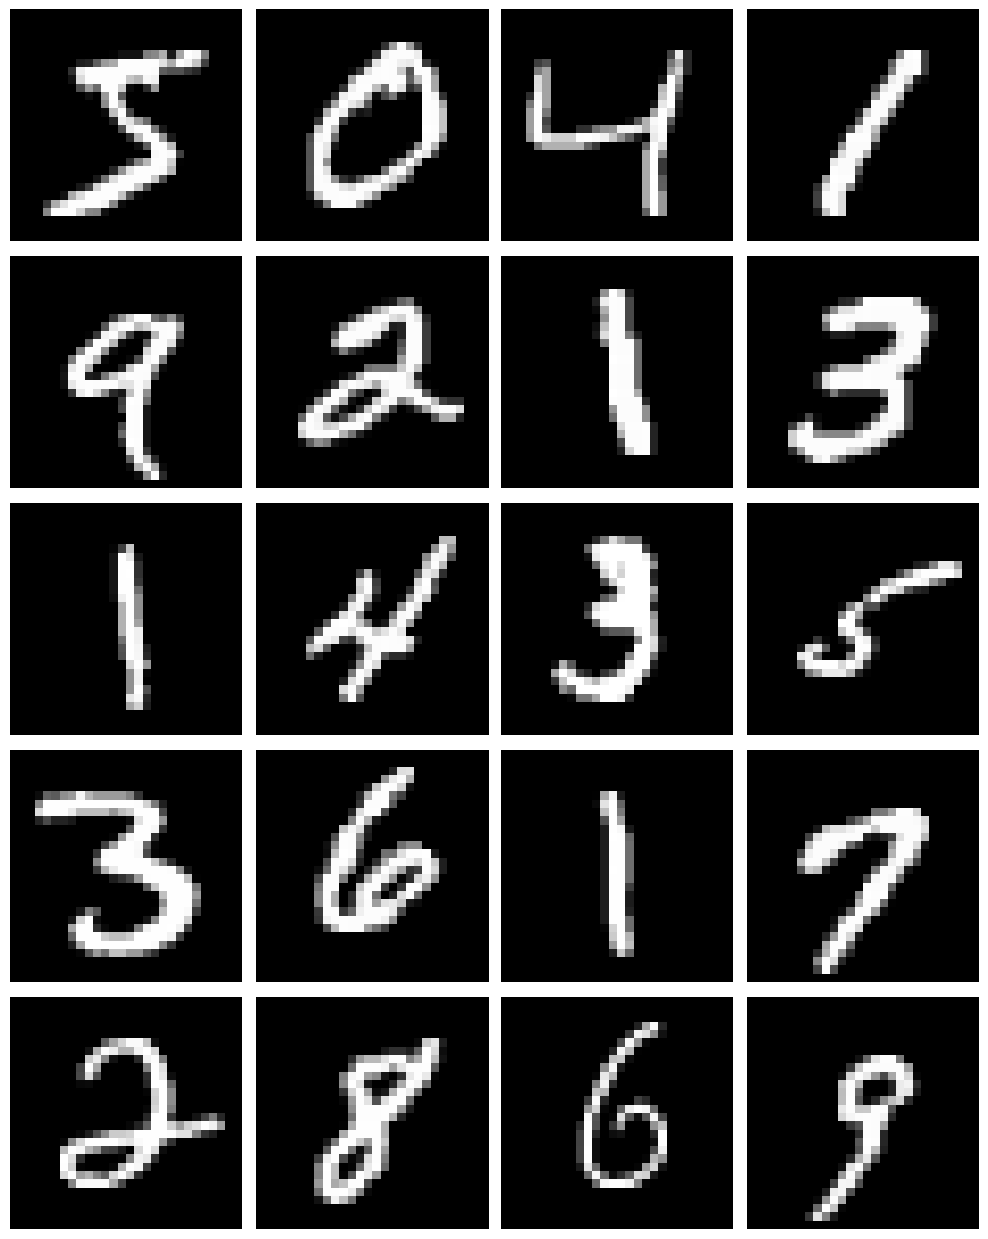

In [13]:
# BEFORE SELECTING AND PADDING
plot_mnist_images(MNIST_images, n_samples=20, cols=4)

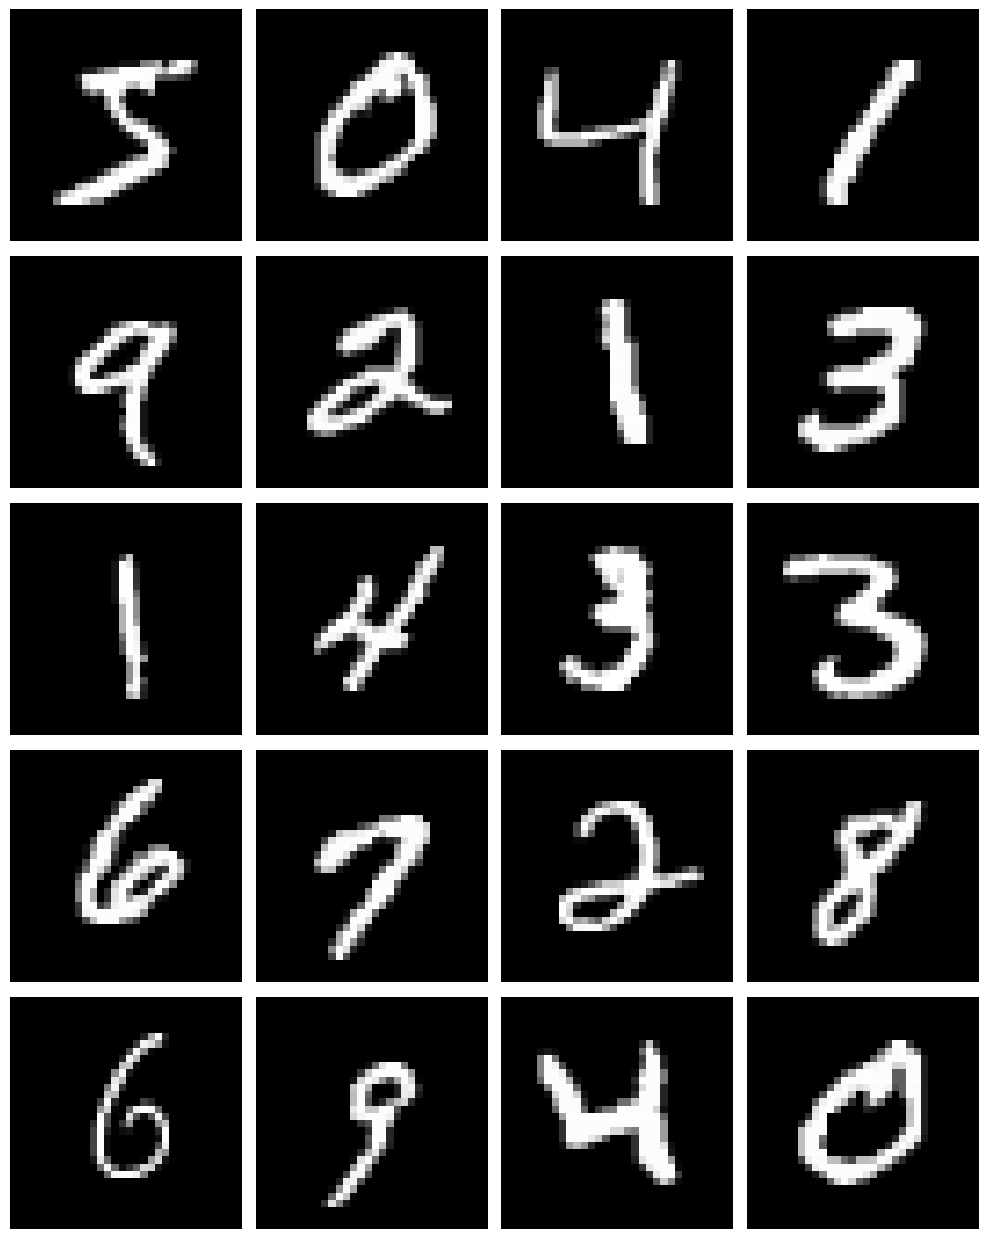

In [11]:
# AFTER SELECTING AND PADDING
plot_mnist_images(padded, n_samples=20, cols=4)

## Load EEG Data

### RAW

In [13]:
import pandas as pd
import numpy as np
import os

path = "/kaggle/input/raw-eeg-2b"
X_batch = pd.read_csv(os.path.join(path, "X_raw_train2B.csv"), header=0)
y_batch = pd.read_csv(os.path.join(path, "y_raw_train2B.csv"), header=0)

X_batch = X_batch.to_numpy()
y_raw = y_batch.to_numpy().flatten()

n_channels = 32
n_timesteps = 256
X_raw = X_batch.reshape(-1, n_channels, n_timesteps)

print(X_raw.shape)
print(y_raw.shape)

(30000, 32, 256)
(30000,)


In [14]:
from keras.utils import to_categorical

X_transposed = X_raw.transpose(0, 2, 1).astype('float32')
y_cat = to_categorical(y_raw, num_classes=10).astype('float32')

print(X_transposed.shape)
print(y_cat.shape)

(30000, 256, 32)
(30000, 10)


In [15]:
from sklearn.model_selection import train_test_split

X_train_raw, X_val_raw,      \
y_train_raw, y_val_raw,      \
img_train_raw, img_val_raw \
    = train_test_split (
        X_transposed, 
        y_cat, 
        images,
        
        test_size    = 0.2,
        random_state = 42, 
        shuffle      = True, 
        stratify     = y_cat
    )

### PREPROCESSED

In [10]:
X_preprocessed = processed['X']
y_preprocessed = processed['y']

print(X_preprocessed.shape)
print(y_preprocessed.shape)

(15460, 32, 125)
(15460,)


In [12]:
from keras.utils import to_categorical

X_transposed_pre = X_preprocessed.transpose(0, 2, 1)
y_cat_pre = to_categorical(y_preprocessed, num_classes=10)

print(X_transposed_pre.shape)
print(y_cat_pre.shape)

(15460, 125, 32)
(15460, 10)


In [13]:
from sklearn.model_selection import train_test_split

X_train_pre, X_val_pre,    \
y_train_pre, y_val_pre,    \
img_train_pre, img_val_pre \
    = train_test_split (
        X_transposed_pre, 
        y_cat_pre,
        combined,
    
        test_size    = 0.2,
        random_state = 42, 
        shuffle      = True, 
        stratify     = y_cat_pre
    )

## Load **Feature Extraction-Classification** and **Image Generation** MODEL

### Feature Extraction & Classification Models

In [19]:
# BEST CLASSIFICATION FOR RAW DATA
import tensorflow as tf
import os

save_dir = f"/kaggle/input/best-lstm-final/keras/default/1"
best_raw_model = tf.keras.models.load_model(os.path.join(save_dir, f'best_trial_LSTM_final.keras'))

I0000 00:00:1751703494.805780      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751703494.806482      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
# BEST CLASSIFICATION FOR PREPROCESSED DATA
import tensorflow as tf
import os

save_dir = f"/kaggle/input/best-lstm-final/keras/default/1"
best_model = tf.keras.models.load_model(os.path.join(save_dir, f'best_LSTM_final.keras'))

I0000 00:00:1751908755.544536      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751908755.545246      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### Image Generation Models

In [15]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x

In [16]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(1, d//2, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(10, d//2, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = generator(128).to(device)
D = discriminator(128).to(device)

generator_path = "/kaggle/input/image-generation-mse/tensorflow2/default/1/MNIST_cDCGAN_generator_param.pkl"
discriminator_path = "/kaggle/input/image-generation-mse/tensorflow2/default/1/MNIST_cDCGAN_discriminator_param.pkl"

# Load parameter
G.load_state_dict(torch.load(generator_path, map_location=device))
D.load_state_dict(torch.load(discriminator_path, map_location=device))

G.eval()
D.eval()

discriminator(
  (conv1_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_2): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

## **FINE-TUNING PIPELINE**: 
#### (EEG + image) => [feature extraction + classification] => **((latent space + class) + image) <=> [image generation]**

### Supporting Functions

In [18]:
from tensorflow.keras.models import Model

def make_pairs(model, X, y, imgs):
    encoder_model = Model(inputs=model.input, outputs=model.get_layer('latent_vector').output)
    encoder_model.compile()
    latent_vectors = encoder_model.predict(X)
    
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y, axis=1)
    true_indices = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i]]

    final_true_pairs = [(latent_vectors[i],
                         y[i],        
                         imgs[i])
                         for i in true_indices]
    
    final_false_pairs = [(latent_vectors[i],
                         y[i],        
                         imgs[i])
                         for i in range(len(y_pred)) 
                         if i not in true_indices]

    return final_true_pairs, final_false_pairs

In [19]:
# [!] G and D will literally change!!
# [!] Re-initialized G and D for second fine-tuning!!

def finetune_gan(G, D, pairs, num_epochs):
    device = next(G.parameters()).device

    # Freeze front layers of generator
    for name, param in G.named_parameters():
        if "deconv1" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Optimizer
    optimizer_G = torch.optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), lr=1e-4)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=1e-4)
    
    # Loss functions
    adversarial_loss = torch.nn.BCELoss()
    mse_loss = torch.nn.MSELoss()
    
    # Weight for adversarial loss
    λ = 0
    
    for epoch in range(num_epochs):
        for latent_input, label_onehot, target_image in pairs:
            latent_input = (latent_input - latent_input.mean()) / latent_input.std()
            latent_input = torch.tensor(latent_input, dtype=torch.float32).to(device)
            latent_input = latent_input.unsqueeze(0).unsqueeze(2).unsqueeze(3)
            
            label_onehot = torch.tensor(label_onehot, dtype=torch.float32).to(device)
            label_onehot = label_onehot.reshape(-1, 10, 1, 1)
            
            target_image = torch.tensor(target_image, dtype=torch.float32).to(device)
            target_image = target_image.unsqueeze(0).unsqueeze(0)
    
            # ======================== GENERATOR ========================
            G.train()
            optimizer_G.zero_grad()
            
            fake_image = G(latent_input, label_onehot)
            label_img = label_onehot.repeat(1, 1, 32, 32)
    
            # Discriminator feedback
            pred_fake = D(fake_image, label_img).squeeze()
    
            # valid_labels = torch.ones_like(pred_fake)
            # loss_adv = adversarial_loss(pred_fake, valid_labels)
    
            # MSE for comparison with ground truth image
            loss_img = mse_loss(fake_image, target_image)
    
            # Combine G loss
            # loss_G =  loss_img + λ * loss_adv
            loss_G = loss_img
            loss_G.backward()
            optimizer_G.step()
    
            
            # ====================== DISCRIMINATOR ======================
            D.train()
            optimizer_D.zero_grad()
    
            # Fake
            pred_fake = D(fake_image.detach(), label_img).squeeze()
            loss_D_fake = adversarial_loss(pred_fake, torch.zeros_like(pred_fake))
    
            # Real
            pred_real = D(target_image, label_img).squeeze()
            loss_D_real = adversarial_loss(pred_real, torch.ones_like(pred_real))
    
            # Combine D loss
            loss_D = (loss_D_fake + loss_D_real)
            loss_D.backward()
            optimizer_D.step()
    
        print(f"[Epoch {epoch+1}] Loss_G: {loss_G.item():.4f} | Loss_D: {loss_D.item():.4f}")
    
    return (G, D)

### RAW EEG DATA

In [26]:
final_raw_pairs, _ = make_pairs(best_raw_model, X_train_raw, y_train_raw, img_train_raw)

I0000 00:00:1751703517.635273     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step


In [ ]:
G_tuned, D_tuned = finetune_gan(G, D, final_raw_pairs, 5)

In [ ]:
# SAVE


### PREPROCESSED EEG DATA

In [20]:
final_pre_pairs, _ = make_pairs(best_model, X_train_pre, y_train_pre, img_train_pre)

I0000 00:00:1751908786.758479      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [ ]:
# Re-initialize G and D


In [ ]:
G_tuned, D_tuned = finetune_gan(G, D, final_pre_pairs, 20)

[Epoch 1] Loss_G: 3643.5269 | Loss_D: 0.0000
[Epoch 2] Loss_G: 3643.3572 | Loss_D: 0.0000
[Epoch 3] Loss_G: 3643.2920 | Loss_D: 0.0000
[Epoch 4] Loss_G: 3643.2549 | Loss_D: 0.0000
[Epoch 5] Loss_G: 3643.2166 | Loss_D: 0.0000
[Epoch 6] Loss_G: 3643.2058 | Loss_D: 0.0000
[Epoch 7] Loss_G: 3643.1934 | Loss_D: 0.0000
[Epoch 8] Loss_G: 3643.1909 | Loss_D: 0.0000
[Epoch 9] Loss_G: 3643.1721 | Loss_D: 0.0000
[Epoch 10] Loss_G: 3643.1660 | Loss_D: 0.0000
[Epoch 11] Loss_G: 3643.1633 | Loss_D: 0.0000
[Epoch 12] Loss_G: 3643.1582 | Loss_D: 0.0000
[Epoch 13] Loss_G: 3643.1570 | Loss_D: 0.0000
[Epoch 14] Loss_G: 3643.1606 | Loss_D: 0.0000
[Epoch 15] Loss_G: 3643.1538 | Loss_D: 0.0000
[Epoch 16] Loss_G: 3643.1514 | Loss_D: 0.0000


In [ ]:
# SAVE

## Evaluation

### Supporting Functions

#### Metrics

In [33]:
# SSIM
from skimage.metrics import structural_similarity as ssim

def SSIM(generated, original):
    score = ssim(generated, original, data_range=original.max() - original.min())
    return score

In [34]:
# PSNR
# Source: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [37]:
# CLIP Score
from torchmetrics.multimodal.clip_score import CLIPScore
from PIL import Image

metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")
number_text = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

def CLIP_score(image, label_onehot):
    try:
        label = int(np.argmax(label_onehot, axis=1).squeeze().item())
    
        image_tensor = torch.tensor(image).float().clamp(0, 1)
        image_tensor = image_tensor.unsqueeze(0).repeat(3,1,1)
        
        score = metric(image_tensor, f"handwritten digit {number_text[label]}")
        return score.item()
    except Exception as e:
        print("CLIP_score error:", e)
        return None

In [35]:
pip install -U git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-c17fmoze
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-c17fmoze
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [36]:
# CLIP Score V2
# Source: https://unimatrixz.com/blog/latent-space-clip-score/

import torch
import clip
from PIL import Image
import torchvision.transforms as T

model, preprocess = clip.load('ViT-B/32')
model = model.to(device)

number_text = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

def get_clip_score(image, label_onehot):
    label = int(np.argmax(label_onehot, axis=1).squeeze().item())
    image_pil = T.ToPILImage()(image)
    image_input = preprocess(image_pil).unsqueeze(0)
    text_input = clip.tokenize([f"MNIST handwritten white digit {number_text[label]} with black background"])
    
    # Move the inputs to GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    image_input = image_input.to(device)
    text_input = text_input.to(device)
    
    # Generate embeddings for the image and text
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_input)
    
    # Normalize the features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # Calculate the cosine similarity to get the CLIP score
    clip_score = torch.matmul(image_features, text_features.T).item()
    
    return clip_score

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 73.3MiB/s]


#### Evaluate

In [31]:
import matplotlib.pyplot as plt

def evaluate_generation(G, D, pairs, n):
    G.eval()
    D.eval()
    cmap='gray'
    plt.figure(figsize=(10, 4 * n))
    
    for i, (latent_input, label_onehot, target_image) in enumerate(pairs[:n]):
        latent_input = torch.tensor(latent_input, dtype=torch.float32).to(device)
        latent_input = latent_input.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    
        label_onehot = torch.tensor(label_onehot, dtype=torch.float32).to(device)
        label_onehot = label_onehot.reshape(-1, 10, 1, 1)
        label_img = label_onehot.repeat(1, 1, 32, 32)
        
        fake_image = G(latent_input, label_onehot)
        pred_fake = D(fake_image, label_img).squeeze()
        
        fake_image = fake_image.squeeze().detach().cpu().numpy()
    
        # Compute Metrics:
        ssim_score = SSIM(fake_image, target_image)
        psnr_score = PSNR(target_image, fake_image)
        clip_score = get_clip_score(fake_image, label_onehot.detach().cpu().numpy())
        
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(fake_image, cmap=cmap)
        plt.title(f"Generated, D Score: {pred_fake:.4f}\nSSIM: {ssim_score:.4f}, PSNR: {psnr_score:.4f}, CLIP Score: {clip_score:.4f}")
        plt.axis("off")
    
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(target_image, cmap=cmap)
        plt.title(f"Ground Truth")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

### RAW DATA

#### TRAIN SET

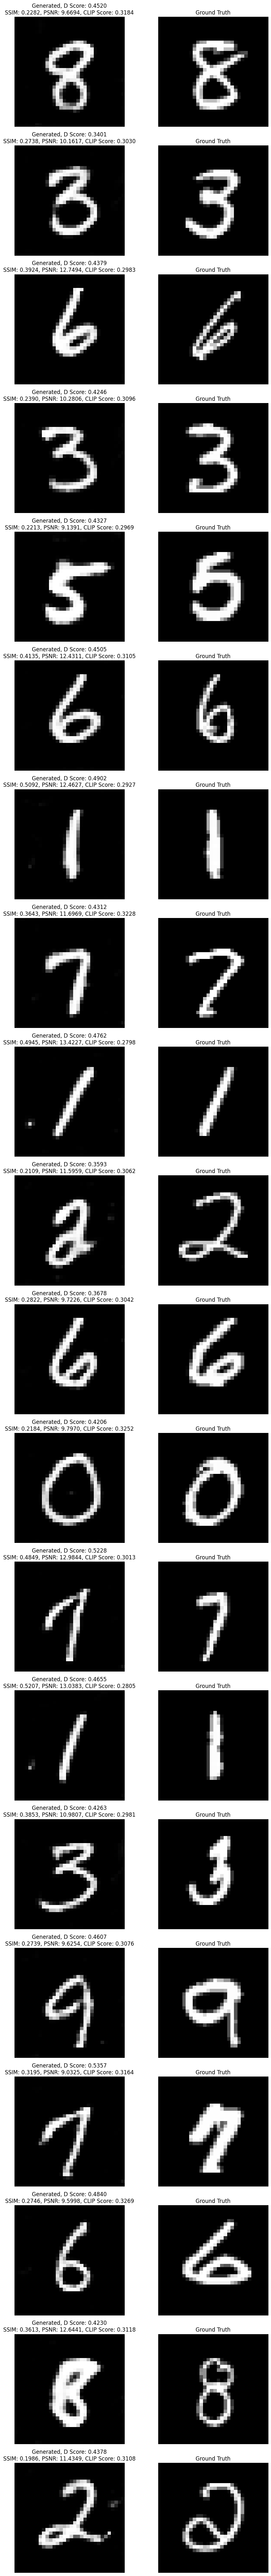

In [53]:
# Without Fine-Tuning
evaluate_generation(G, D, final_raw_pairs, 20)

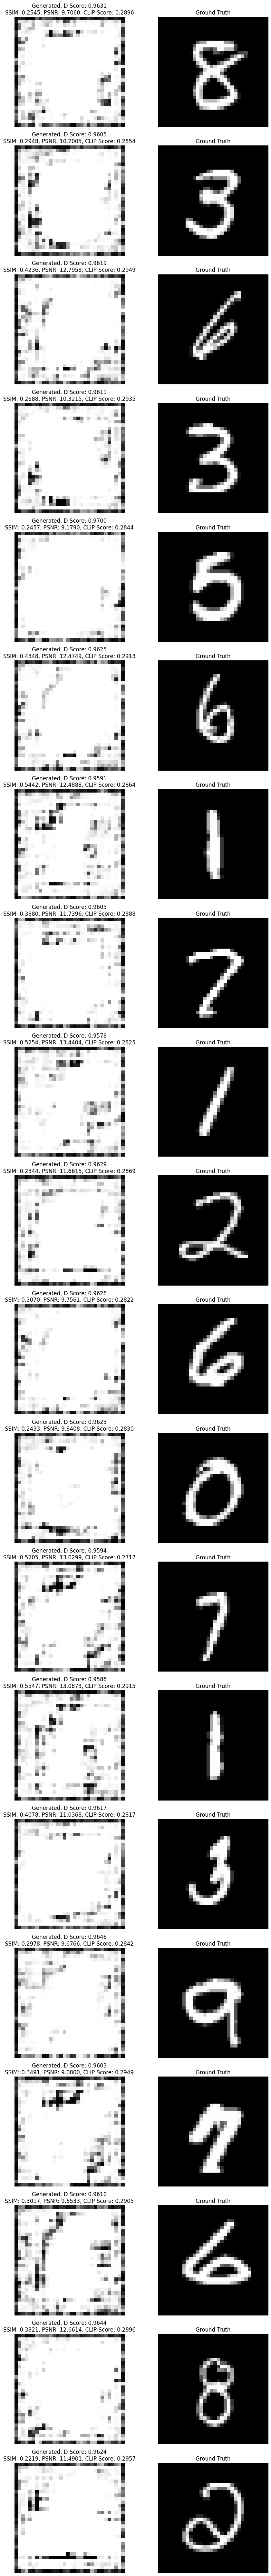

In [66]:
# With Fine-Tuning
evaluate_generation(G_tuned, D_tuned, final_raw_pairs, 20)

#### VALIDATION SET

In [79]:
final_raw_val_pairs, _ = make_pairs(best_raw_model, X_val_raw, y_val_raw, img_val_raw)

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


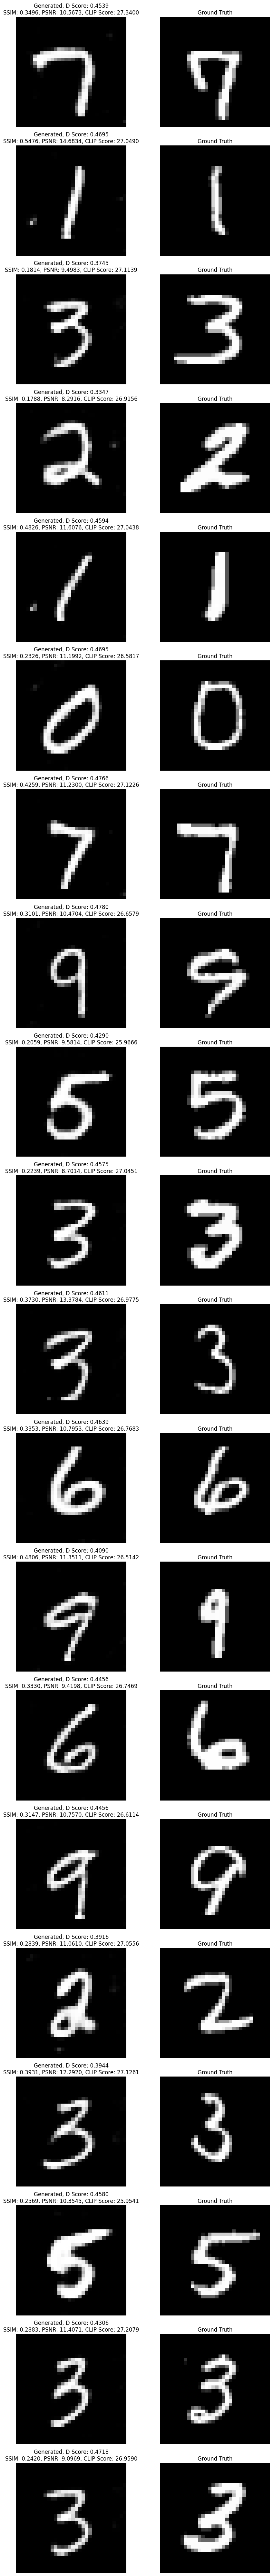

In [82]:
# Without Fine-Tuning
evaluate_generation(G, D, final_raw_val_pairs, 20)

In [ ]:
# With Fine-Tuning

### PREPROCESSED DATA

#### TRAIN SET

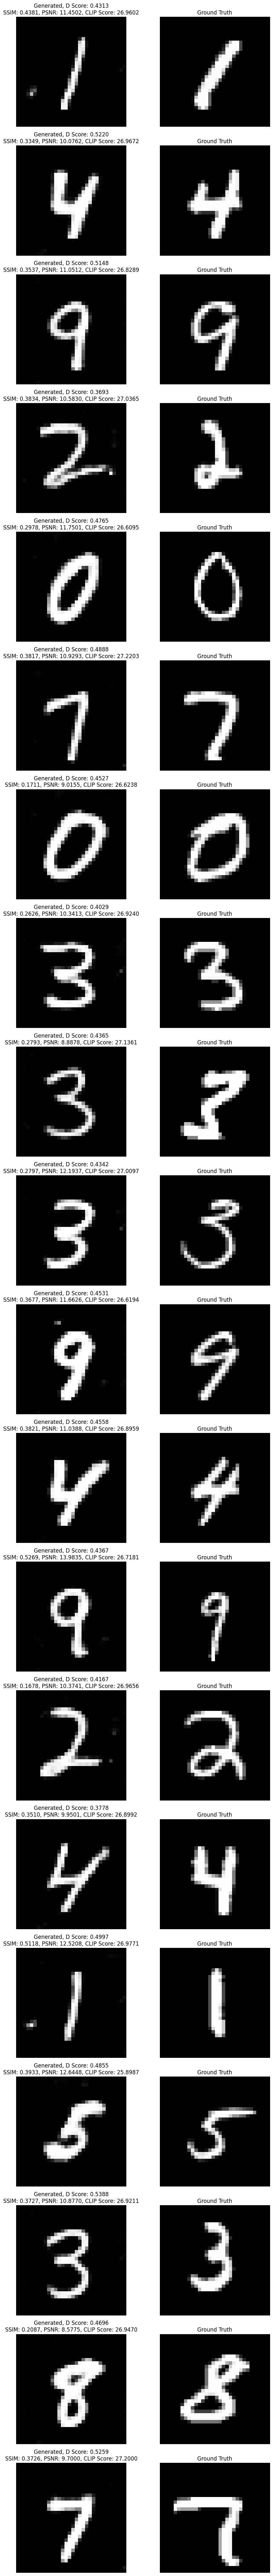

In [84]:
# Without Fine-Tuning
evaluate_generation(G, D, final_pre_pairs, 20)

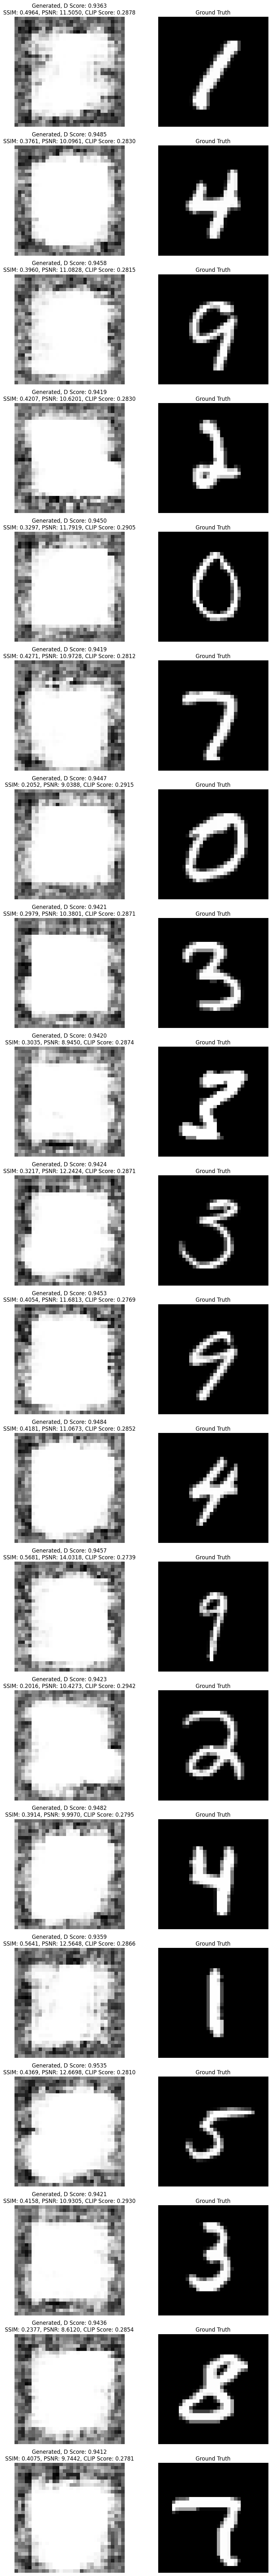

In [37]:
# With Fine-Tuning
evaluate_generation(G_tuned, D_tuned, final_pre_pairs, 20)

#### VALIDATION SET

In [38]:
final_pre_val_pairs, _ = make_pairs(best_model, X_val_pre, y_val_pre, img_val_pre)

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


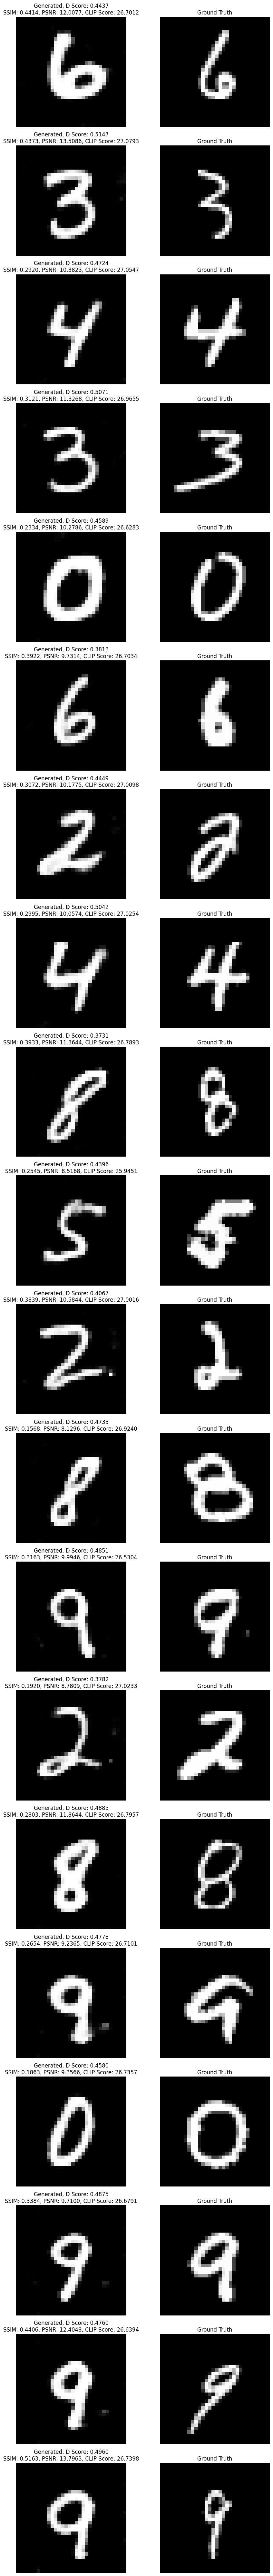

In [86]:
# Without Fine-Tuning
evaluate_generation(G, D, final_pre_val_pairs, 20)

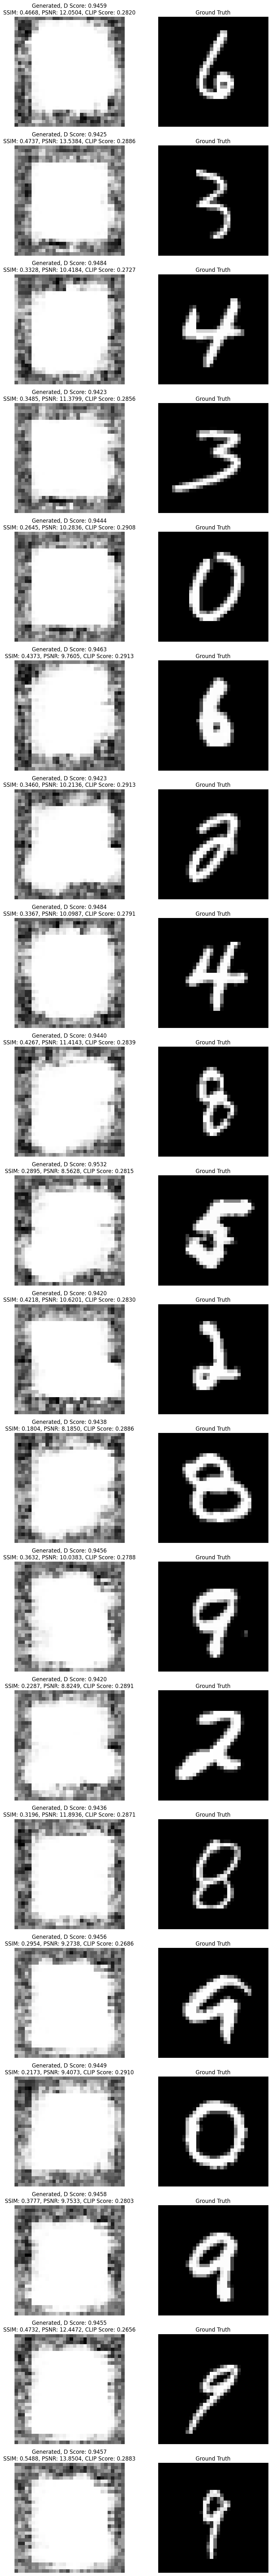

In [39]:
# With Fine-Tuning
evaluate_generation(G_tuned, D_tuned, final_pre_val_pairs, 20)